# Amazon Fine Food Review and Rating Score (Sentiment Analysis)

In [47]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', context='talk')
import warnings 
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore')
import nltk

#include modules
from modules.data_preprocessing import remove_tags
from modules.model import blob_senti,vader_senti


In [48]:
# Read in data
df = pd.read_csv('../data/Reviews_data.csv')
print(df.shape)

(2000, 10)


In [49]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...


In [50]:
example_pos = df['Text'][4]
print(example_pos)

Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.


In [51]:
example_neg = df['Text'][50]
print(example_neg)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


# EDA

In [52]:
df.info() #summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      2000 non-null   float64
 1   ProductId               2000 non-null   object 
 2   UserId                  2000 non-null   object 
 3   ProfileName             2000 non-null   object 
 4   HelpfulnessNumerator    2000 non-null   float64
 5   HelpfulnessDenominator  2000 non-null   float64
 6   Score                   2000 non-null   float64
 7   Time                    2000 non-null   float64
 8   Summary                 2000 non-null   object 
 9   Text                    2000 non-null   object 
dtypes: float64(5), object(5)
memory usage: 156.4+ KB


**Note:** The above output shows that there is no any NULL value in the dataset.

In [53]:
# drop the columns which we does not require
df.drop(columns=['HelpfulnessNumerator','HelpfulnessDenominator','Summary','ProfileName'],inplace=True)

In [54]:
df['Time'].value_counts()

Time
1.322438e+09    10
1.350346e+09     7
1.314490e+09     7
1.347149e+09     7
1.261786e+09     7
                ..
1.230595e+09     1
1.211674e+09     1
1.210205e+09     1
1.201651e+09     1
1.265760e+09     1
Name: count, Length: 1134, dtype: int64

**Note:** We have to convert this timestamp to date

In [55]:
df['review_dt']= pd.to_datetime(df['Time'], unit='s')
df['review_dt']

0      2011-04-27
1      2012-09-07
2      2008-08-18
3      2011-06-13
4      2012-10-21
          ...    
1995   2010-02-11
1996   2010-07-24
1997   2009-08-19
1998   2010-02-10
1999   2008-03-30
Name: review_dt, Length: 2000, dtype: datetime64[ns]

In [56]:
#Drop Time column
df.drop(columns=['Time'],inplace=True)

In [57]:
df.head()

,Id,ProductId,UserId,Score,Text,review_dt
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,5.0,I have bought several of the Vitality canned d...,2011-04-27
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,1.0,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,4.0,This is a confection that has been around a fe...,2008-08-18
3,4.0,B000UA0QIQ,A395BORC6FGVXV,2.0,If you are looking for the secret ingredient i...,2011-06-13
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,5.0,Great taffy at a great price. There was a wid...,2012-10-21


In [58]:
#check for duplicate values
df.duplicated().sum()

0

**Note:** It shows there is no duplicate records in the dataset.

In [59]:
# remove the html tags form the Text(Review)
df['with_out_tags']=df['Text'].apply(lambda cw : remove_tags(cw))

In [60]:
df['with_out_tags'][1010]

"I tried this and I found it too salty.Plus I ate this fish sauce with some fish but I realized it was kind of redundant.I'm kidding, of course. This stuff is great!"

In [61]:
df.drop(columns=['Text'],inplace=True)

In [62]:
#rename Score to Rating
df.rename(columns={'Score':'Rating','with_out_tags':'Text'},inplace=True)

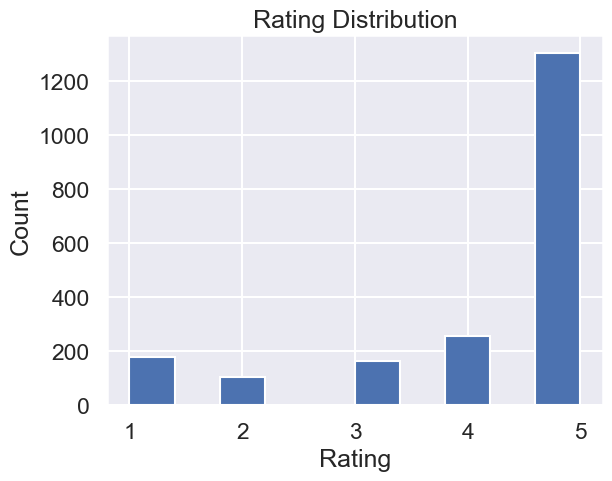

In [63]:
#score distribution
plt.hist(df['Rating'])
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Using TextBlob

In [64]:
from textblob import TextBlob

# test with example
analysisPol = TextBlob(example_pos).polarity
print(analysisPol)
analysisPol2 = TextBlob(example_neg).polarity
print(analysisPol2)

0.48333333333333334
-0.12499999999999999


In [65]:
blob = {}
# Run on the entire dataset
for i, row in df.iterrows():
        text = row['Text']
        myid = row['Id']
        t=TextBlob(text).polarity
        blob[myid] =dict({'blob_score':t})


In [66]:
blob_df = pd.DataFrame(blob).T
blob_df.head()


,blob_score
1.0,0.450000
2.0,-0.033333
3.0,0.133571
4.0,0.166667
5.0,0.483333


In [67]:

blob_df['blob_sentiment']=blob_df['blob_score'].apply(lambda x: blob_senti(x))
blob_df.head()

,blob_score,blob_sentiment
1.0,0.450000,POSITIVE
2.0,-0.033333,NEGATIVE
3.0,0.133571,POSITIVE
4.0,0.166667,POSITIVE
5.0,0.483333,POSITIVE


# Using VADER

In [68]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [69]:
sentiment=SentimentIntensityAnalyzer()
#test on example
sent_ex=sentiment.polarity_scores(example_pos)
sent_ex

{'neg': 0.0, 'neu': 0.599, 'pos': 0.401, 'compound': 0.9468}

In [70]:
sent_ex1=sentiment.polarity_scores(example_neg)
sent_ex1

{'neg': 0.21, 'neu': 0.79, 'pos': 0.0, 'compound': -0.5448}

In [71]:
# Run the polarity score on the entire dataset
res = {}
for i, row in df.iterrows():
        text = row['Text']
        myid = row['Id']
        res[myid] = sentiment.polarity_scores(text)
    

In [72]:
vaders_df = pd.DataFrame(res).T
vaders_df.head()

,neg,neu,pos,compound
1.0,0.000,0.711,0.289,0.9441
2.0,0.138,0.862,0.000,-0.5664
3.0,0.085,0.771,0.144,0.8138
4.0,0.000,0.932,0.068,0.4404
5.0,0.000,0.599,0.401,0.9468


In [73]:
#keep only compound
vaders_df.drop(columns=['neg','neu','pos'],inplace=True)

In [74]:
# create a categorical sentiment

vaders_df['sentiment']=vaders_df['compound'].apply(lambda x: vader_senti(x))


In [75]:
#rename columns
vaders_df.rename(columns={'compound':'vader_score',
                       'sentiment':'vader_sentiment'
                     },inplace=True)
vaders_df.columns

Index(['vader_score', 'vader_sentiment'], dtype='object')

In [76]:
vaders_df.head()

,vader_score,vader_sentiment
1.0,0.9441,POSITIVE
2.0,-0.5664,NEGATIVE
3.0,0.8138,POSITIVE
4.0,0.4404,POSITIVE
5.0,0.9468,POSITIVE


# Transformer Pipeline

In [77]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis",padding=True, truncation=True)
# Teset pipeline
data = [example_pos, example_neg]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


[{'label': 'POSITIVE', 'score': 0.9987082481384277},
 {'label': 'NEGATIVE', 'score': 0.9994776844978333}]

In [78]:
# Run the sentiment_pipeline on the entire dataset
res_pipe=sentiment_pipeline(list(df['Text']))


In [79]:
pipe_df = pd.DataFrame(res_pipe)
pipe_df.head()

,label,score
0,POSITIVE,0.998385
1,NEGATIVE,0.999525
2,POSITIVE,0.999765
3,POSITIVE,0.999153
4,POSITIVE,0.998708


In [80]:
pipe_df.index = (pipe_df.index + 1).astype('float') #as index starts from 0 we need it from 1.0
pipe_df.head()

,label,score
1.0,POSITIVE,0.998385
2.0,NEGATIVE,0.999525
3.0,POSITIVE,0.999765
4.0,POSITIVE,0.999153
5.0,POSITIVE,0.998708


In [81]:
#change the score sign according to the sentiment
pipe_df['pipe_score'] = np.where((pipe_df['label'] == 'NEGATIVE'), ((-1)*(pipe_df['score'])), pipe_df['score'])

In [82]:
pipe_df.head()

,label,score,pipe_score
1.0,POSITIVE,0.998385,0.998385
2.0,NEGATIVE,0.999525,-0.999525
3.0,POSITIVE,0.999765,0.999765
4.0,POSITIVE,0.999153,0.999153
5.0,POSITIVE,0.998708,0.998708


In [83]:
#rename columns
pipe_df.rename(columns={'score':'pipe_abs_score',
                       'label':'pipe_sentiment'
                     },inplace=True)
pipe_df.columns

Index(['pipe_sentiment', 'pipe_abs_score', 'pipe_score'], dtype='object')

# Merge sentiments with metadata

In [84]:
#Reset index for sentiment dataframes
blob_df = blob_df.reset_index().rename(columns={'index': 'Id'}) #TextBlob
vaders_df = vaders_df.reset_index().rename(columns={'index': 'Id'}) #VADER
pipe_df = pipe_df.reset_index().rename(columns={'index': 'Id'}) #Pipeline

In [85]:
#Join these dataframes
vaders_blob_df = vaders_df.merge(blob_df, how='left')
blob_vaders_pipe_df = pipe_df.merge(vaders_blob_df, how='left')
blob_vaders_pipe_df.head()

,Id,pipe_sentiment,pipe_abs_score,pipe_score,vader_score,vader_sentiment,blob_score,blob_sentiment
0,1.0,POSITIVE,0.998385,0.998385,0.9441,POSITIVE,0.450000,POSITIVE
1,2.0,NEGATIVE,0.999525,-0.999525,-0.5664,NEGATIVE,-0.033333,NEGATIVE
2,3.0,POSITIVE,0.999765,0.999765,0.8138,POSITIVE,0.133571,POSITIVE
3,4.0,POSITIVE,0.999153,0.999153,0.4404,POSITIVE,0.166667,POSITIVE
4,5.0,POSITIVE,0.998708,0.998708,0.9468,POSITIVE,0.483333,POSITIVE


In [86]:
#merge this dataframe with dataset
result_df=blob_vaders_pipe_df.merge(df,how='left')
result_df.head()

,Id,pipe_sentiment,pipe_abs_score,pipe_score,vader_score,vader_sentiment,blob_score,blob_sentiment,ProductId,UserId,Rating,review_dt,Text
0,1.0,POSITIVE,0.998385,0.998385,0.9441,POSITIVE,0.450000,POSITIVE,B001E4KFG0,A3SGXH7AUHU8GW,5.0,2011-04-27,I have bought several of the Vitality canned d...
1,2.0,NEGATIVE,0.999525,-0.999525,-0.5664,NEGATIVE,-0.033333,NEGATIVE,B00813GRG4,A1D87F6ZCVE5NK,1.0,2012-09-07,Product arrived labeled as Jumbo Salted Peanut...
2,3.0,POSITIVE,0.999765,0.999765,0.8138,POSITIVE,0.133571,POSITIVE,B000LQOCH0,ABXLMWJIXXAIN,4.0,2008-08-18,This is a confection that has been around a fe...
3,4.0,POSITIVE,0.999153,0.999153,0.4404,POSITIVE,0.166667,POSITIVE,B000UA0QIQ,A395BORC6FGVXV,2.0,2011-06-13,If you are looking for the secret ingredient i...
4,5.0,POSITIVE,0.998708,0.998708,0.9468,POSITIVE,0.483333,POSITIVE,B006K2ZZ7K,A1UQRSCLF8GW1T,5.0,2012-10-21,Great taffy at a great price. There was a wid...


In [87]:
# save the sentiment output
result_df.to_csv('../output/sentiment_result.csv', index=False)

# Model Comparision

In [88]:
#result_df=pd.read_csv('../output/sentiment_result.csv')

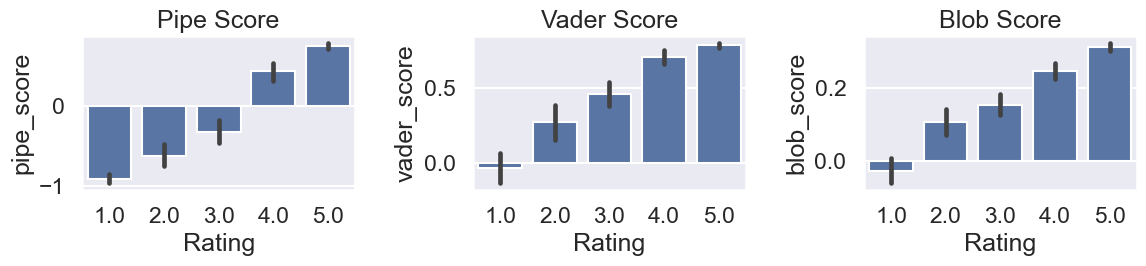

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=result_df, x='Rating', y='pipe_score', ax=axs[0])
sns.barplot(data=result_df, x='Rating', y='vader_score', ax=axs[1])
sns.barplot(data=result_df, x='Rating', y='blob_score', ax=axs[2])
axs[0].set_title('Pipe Score')
axs[1].set_title('Vader Score')
axs[2].set_title('Blob Score')
plt.tight_layout()
plt.show()

**Calculate R2-Score**
- But before it we have to rescale the Rating column

In [90]:
result_df['Rating_scaled']=result_df['Rating'].apply(lambda x: ((x-1)/2)-1 )

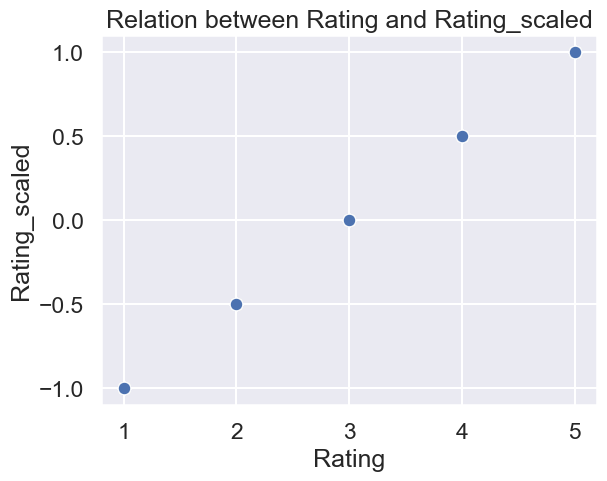

In [91]:
#Plot Rating
ax = sns.scatterplot(data=result_df, x='Rating', y='Rating_scaled')
ax.set_title('Relation between Rating and Rating_scaled')
plt.show()

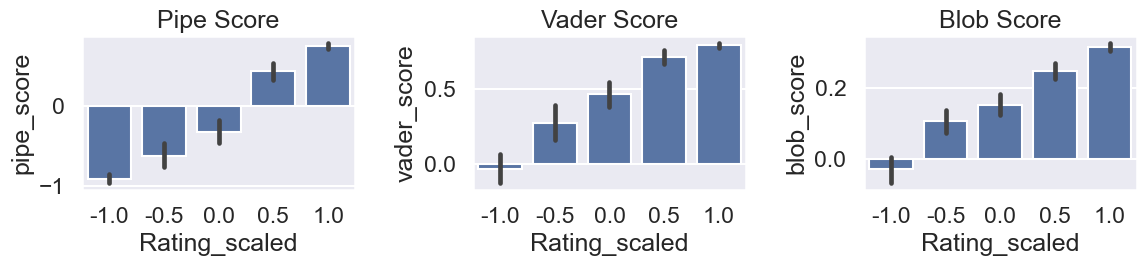

In [92]:
#plot scores with scaled rating
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=result_df, x='Rating_scaled', y='pipe_score', ax=axs[0])
sns.barplot(data=result_df, x='Rating_scaled', y='vader_score', ax=axs[1])
sns.barplot(data=result_df, x='Rating_scaled', y='blob_score', ax=axs[2])
axs[0].set_title('Pipe Score')
axs[1].set_title('Vader Score')
axs[2].set_title('Blob Score')
plt.tight_layout()
plt.show()

In [93]:
from sklearn.metrics import r2_score

In [94]:
r2_score(result_df['Rating_scaled'], result_df['pipe_score'])

-0.22463089640421274

In [95]:
r2_score(result_df['Rating_scaled'], result_df['vader_score'])

0.2613213097924604

In [96]:
r2_score(result_df['Rating_scaled'], result_df['blob_score'])

-0.08506241083505217

**Calculate Standard Deviation**

In [97]:
#calculate standard deviation of 'pipe_score','vader_score' and 'blob_score' columns
result_df['std_dev']=result_df[['pipe_score','vader_score','blob_score']].std(axis = 1)

In [98]:
result_df['std_dev']

0       0.302161
1       0.483957
2       0.455994
3       0.424297
4       0.283757
          ...   
1995    0.444111
1996    0.408074
1997    0.966735
1998    0.852953
1999    0.060801
Name: std_dev, Length: 2000, dtype: float64

In [99]:
# save the comparison dataframe as output
result_df.to_csv('../output/sentiment_result_comparison.csv', index=False)

In [100]:
#result_df=pd.read_csv('../output/sentiment_result_comparison.csv')

**Ground True Values**

In [101]:
result_subset=result_df.sort_values(by='std_dev',ascending=False).head(10)

In [102]:
result_subset[['Id','pipe_sentiment','vader_sentiment','blob_sentiment','Text','std_dev']]

,Id,pipe_sentiment,vader_sentiment,blob_sentiment,Text,std_dev
106,107.0,NEGATIVE,POSITIVE,POSITIVE,not what I was expecting in terms of the compa...,1.052842
1115,1116.0,NEGATIVE,POSITIVE,POSITIVE,Who doesn't like vegetables that are portable ...,1.040915
1010,1011.0,NEGATIVE,POSITIVE,POSITIVE,I tried this and I found it too salty.Plus I a...,1.039944
548,549.0,NEGATIVE,POSITIVE,POSITIVE,They are good but wish they were also baked. H...,1.037647
1818,1819.0,NEGATIVE,POSITIVE,POSITIVE,"If you are trying to eat healthy (like me), bu...",1.021908
848,849.0,NEGATIVE,POSITIVE,POSITIVE,This baking soda works great for cooking or fo...,1.019657
1020,1021.0,NEGATIVE,POSITIVE,POSITIVE,You could find this in local supermarkets abou...,1.014021
1424,1425.0,NEGATIVE,POSITIVE,POSITIVE,"Forget Starbucks, Peets or anything else. This...",1.012542
724,725.0,NEGATIVE,POSITIVE,POSITIVE,They did a very good job with shipping the ord...,1.008694
1281,1282.0,NEGATIVE,POSITIVE,POSITIVE,They're perfect training treats for my dogs. ...,1.002878


In [103]:
for i, row in result_subset.iterrows():
    print(row['Text'])
    print('--------------------------------------------------')

not what I was expecting in terms of the company's reputation for excellent home delivery products
--------------------------------------------------
Who doesn't like vegetables that are portable and at a great price?  Can't beat the convenience at about 4 cents per package!
--------------------------------------------------
I tried this and I found it too salty.Plus I ate this fish sauce with some fish but I realized it was kind of redundant.I'm kidding, of course. This stuff is great!
--------------------------------------------------
They are good but wish they were also baked. Have not found baked no salt potato chips anywhere. If there are any I wish someone would post.
--------------------------------------------------
If you are trying to eat healthy (like me), but love junk food (like me), these are the chips for you.  I have given up potato chips and french fries in my quest to eat guilt free, but a sandwich just needs something on the side. These chips add a great crunch as a

**Note:** we can see that the sentiment of all the reviews above is NEGATIVE so Transformer Pipeline failed to predict these.Lets manually give some label to these reviews and try another model.

In [104]:
result_subset['Text'][106]

"not what I was expecting in terms of the company's reputation for excellent home delivery products"

In [105]:
result_subset.at[106, 'ground_true_label']='NEGATIVE'

In [106]:
result_subset['Text'][1115]

"Who doesn't like vegetables that are portable and at a great price?  Can't beat the convenience at about 4 cents per package!"

In [107]:
result_subset.at[1115, 'ground_true_label']='POSITIVE'

In [108]:
result_subset['Text'][1010]

"I tried this and I found it too salty.Plus I ate this fish sauce with some fish but I realized it was kind of redundant.I'm kidding, of course. This stuff is great!"

In [109]:
result_subset.at[1010, 'ground_true_label']='POSITIVE'

In [110]:
result_subset['Text'][548]

'They are good but wish they were also baked. Have not found baked no salt potato chips anywhere. If there are any I wish someone would post.'

In [111]:
result_subset.at[548, 'ground_true_label']='NEGATIVE'

In [112]:
result_subset['Text'][1818]

'If you are trying to eat healthy (like me), but love junk food (like me), these are the chips for you.  I have given up potato chips and french fries in my quest to eat guilt free, but a sandwich just needs something on the side. These chips add a great crunch as a side to a sandwich, and are a great snack for only 100 calories. They have no preservatives, no artificial flavors or colors, no cholesterol, 0 grams saturated fat, o grams trans fat, and are gluten free. Ingredients are potato flakes, potato starch, safflower oil and/or sunflower oil, rice flour, sea salt. They would be great to pack in a school lunch or for an after school snack. I ordered them on the subscription plan, a case a month, but might have to add an extra shipment. Everyone I have given a pack to loved them too and came back for more.'

In [113]:
result_subset.at[1818, 'ground_true_label']='POSITIVE'

In [114]:
result_subset['Text'][848]

"This baking soda works great for cooking or for health reasons.  I take it for acid indigestion and heart burn.  Just a 1 tsp in a half glass of water and it's gone.  I use it to make my body more alkaline, so it's great for changing your pH level in your body!"

In [115]:
result_subset.at[848, 'ground_true_label']='POSITIVE'

In [116]:
result_subset['Text'][1020]

"You could find this in local supermarkets about 4 months ago but now it nowhere to be found. Every time Kellogg's makes a great cereal, they quit making it soon after. This is the case with Just Right, THAT WAS THE BEST STUFF ON THE PLANET!"

In [117]:
result_subset.at[1020, 'ground_true_label']='POSITIVE'

In [118]:
result_subset['Text'][1424]

"Forget Starbucks, Peets or anything else. This is the real deal. Like a good vintage wine, Britt coffee is truly gourmet with no after taste! I am really fussy about coffee, and generally avoid it, but after a trip to Costa Rica fell in love with the beverage again! You have to use a French Press to get the full favor so throw away those other coffee making contraptions, your beans deserve the best, your taste buds deserve the best too. No I don't work for Britt and did not get paid to say this!!!!!  But if you guys at Britt read this send me a sample or two!!"

In [119]:
result_subset.at[1424, 'ground_true_label']='POSITIVE'

In [120]:
result_subset['Text'][724]

'They did a very good job with shipping the order quickly....Nothing like Ace Hardware who took a week to ship'

In [121]:
result_subset.at[724, 'ground_true_label']='POSITIVE'

In [122]:
result_subset['Text'][1281]

"They're perfect training treats for my dogs.  They go to the place where they're stored and stand there until I get a handful for our play games."

In [123]:
result_subset.at[1281, 'ground_true_label']='POSITIVE'

In [124]:
result_subset

,Id,pipe_sentiment,pipe_abs_score,pipe_score,vader_score,vader_sentiment,blob_score,blob_sentiment,ProductId,UserId,Rating,review_dt,Text,Rating_scaled,std_dev,ground_true_label
106,107.0,NEGATIVE,0.999541,-0.999541,0.5719,POSITIVE,1.000000,POSITIVE,B004K2IHUO,A1ZKFQLHFZAEH9,3.0,2009-03-07,not what I was expecting in terms of the compa...,0.0,1.052842,NEGATIVE
1115,1116.0,NEGATIVE,0.997961,-0.997961,0.5076,POSITIVE,1.000000,POSITIVE,B00469VHRG,A1SB0MNI6H90DG,5.0,2011-10-12,Who doesn't like vegetables that are portable ...,1.0,1.040915,POSITIVE
1010,1011.0,NEGATIVE,0.991306,-0.991306,0.8197,POSITIVE,0.800000,POSITIVE,B0002MKFEM,A3QLX72AO0DD5Z,5.0,2008-11-11,I tried this and I found it too salty.Plus I a...,1.0,1.039944,POSITIVE
548,549.0,NEGATIVE,0.997314,-0.997314,0.8855,POSITIVE,0.700000,POSITIVE,B000G6RYNE,A6UFSCD6O8JMT,4.0,2009-11-01,They are good but wish they were also baked. H...,0.5,1.037647,NEGATIVE
1818,1819.0,NEGATIVE,0.996634,-0.996634,0.9917,POSITIVE,0.407143,POSITIVE,B001RVFDOO,A1RP76H33ZV6P5,5.0,2011-09-21,"If you are trying to eat healthy (like me), bu...",1.0,1.021908,POSITIVE
848,849.0,NEGATIVE,0.999288,-0.999288,0.9321,POSITIVE,0.533333,POSITIVE,B0041CKRJC,A2EIIDTYMJAEXV,5.0,2012-08-29,This baking soda works great for cooking or fo...,1.0,1.019657,POSITIVE
1020,1021.0,NEGATIVE,0.986645,-0.986645,0.9417,POSITIVE,0.521429,POSITIVE,B001E6KBSK,A1CLBQQ7A77FSI,5.0,2010-10-15,You could find this in local supermarkets abou...,1.0,1.014021,POSITIVE
1424,1425.0,NEGATIVE,0.989084,-0.989084,0.9759,POSITIVE,0.417500,POSITIVE,B00061NJ06,A2646GV1ORUO88,5.0,2007-05-23,"Forget Starbucks, Peets or anything else. This...",1.0,1.012542,POSITIVE
724,725.0,NEGATIVE,0.936650,-0.936650,0.6901,POSITIVE,0.910000,POSITIVE,B000G6MBX2,A1KBNKFKAWYV7L,5.0,2007-08-10,They did a very good job with shipping the ord...,1.0,1.008694,POSITIVE
1281,1282.0,NEGATIVE,0.857408,-0.857408,0.7269,POSITIVE,1.000000,POSITIVE,B000WNJ73Q,A219LI5KK8V8R1,5.0,2011-02-25,They're perfect training treats for my dogs. ...,1.0,1.002878,POSITIVE


**Note:** Lets try some another model

# Model: juliensimon/reviews-sentiment-analysis

In [125]:
pipe = pipeline("text-classification", model="juliensimon/reviews-sentiment-analysis")

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [126]:
pipe('I love it') #positive

[{'label': 'LABEL_1', 'score': 0.9240886569023132}]

In [127]:
pipe('I hate it') #negative

[{'label': 'LABEL_0', 'score': 0.9973028898239136}]

In [128]:
res_pipe2=pipe(list(result_subset['Text']))

In [129]:
res_pipe2

[{'label': 'LABEL_0', 'score': 0.9964134097099304},
 {'label': 'LABEL_1', 'score': 0.9236432313919067},
 {'label': 'LABEL_0', 'score': 0.8722413778305054},
 {'label': 'LABEL_0', 'score': 0.7581215500831604},
 {'label': 'LABEL_1', 'score': 0.8966576457023621},
 {'label': 'LABEL_1', 'score': 0.7396499514579773},
 {'label': 'LABEL_0', 'score': 0.6397122144699097},
 {'label': 'LABEL_0', 'score': 0.8544692993164062},
 {'label': 'LABEL_1', 'score': 0.8178116083145142},
 {'label': 'LABEL_1', 'score': 0.9664928317070007}]

In [130]:
pipe2_subset_df = pd.DataFrame(res_pipe2,index=result_subset.index)
pipe2_subset_df['pipe2_sentiment']=''
pipe2_subset_df['pipe2_sentiment'] = np.where((pipe2_subset_df['label'] == 'LABEL_0'),
                                              'NEGATIVE', 'POSITIVE')
pipe2_subset_df.head(10)

,label,score,pipe2_sentiment
106,LABEL_0,0.996413,NEGATIVE
1115,LABEL_1,0.923643,POSITIVE
1010,LABEL_0,0.872241,NEGATIVE
548,LABEL_0,0.758122,NEGATIVE
1818,LABEL_1,0.896658,POSITIVE
848,LABEL_1,0.739650,POSITIVE
1020,LABEL_0,0.639712,NEGATIVE
1424,LABEL_0,0.854469,NEGATIVE
724,LABEL_1,0.817812,POSITIVE
1281,LABEL_1,0.966493,POSITIVE


In [131]:
result_subset_pipe2=pipe2_subset_df.merge(result_subset,how='left', left_index=True, right_index=True)

In [132]:
#lets compare sentiment with ground true labels
result_subset_pipe2[['pipe2_sentiment','pipe_sentiment','vader_sentiment','blob_sentiment','ground_true_label']]

,pipe2_sentiment,pipe_sentiment,vader_sentiment,blob_sentiment,ground_true_label
106,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE
1115,POSITIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE
1010,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE
548,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE
1818,POSITIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE
848,POSITIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE
1020,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE
1424,NEGATIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE
724,POSITIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE
1281,POSITIVE,NEGATIVE,POSITIVE,POSITIVE,POSITIVE


In [133]:
# we can see that pipe2_sentiment works better than the rest
#lets run this in entire dataset
julien_pipe=pipe(list(result_df['Text']),padding=True, truncation=True)

In [134]:
julien_pipe_df = pd.DataFrame(julien_pipe,index=result_df.index)
julien_pipe_df['julien_sentiment']=''
julien_pipe_df['julien_sentiment'] = np.where((julien_pipe_df['label'] == 'LABEL_0'),
                                              'NEGATIVE', 'POSITIVE')
julien_pipe_df.head()

,label,score,julien_sentiment
0,LABEL_1,0.962997,POSITIVE
1,LABEL_0,0.968888,NEGATIVE
2,LABEL_1,0.980880,POSITIVE
3,LABEL_1,0.767588,POSITIVE
4,LABEL_1,0.988336,POSITIVE


In [135]:
#change the score sign according to the sentiment
julien_pipe_df['julien_score'] = np.where((julien_pipe_df['label'] == 'LABEL_0'), 
                                          ((-1)*(julien_pipe_df['score'])), julien_pipe_df['score'])
julien_pipe_df.drop(columns=['label','score'],inplace=True)
julien_pipe_df.head()

,julien_sentiment,julien_score
0,POSITIVE,0.962997
1,NEGATIVE,-0.968888
2,POSITIVE,0.980880
3,POSITIVE,0.767588
4,POSITIVE,0.988336


In [136]:
result_final_df=julien_pipe_df.merge(result_df,how='left', left_index=True, right_index=True)
result_final_df.head()

,julien_sentiment,julien_score,Id,pipe_sentiment,pipe_abs_score,pipe_score,vader_score,vader_sentiment,blob_score,blob_sentiment,ProductId,UserId,Rating,review_dt,Text,Rating_scaled,std_dev
0,POSITIVE,0.962997,1.0,POSITIVE,0.998385,0.998385,0.9441,POSITIVE,0.450000,POSITIVE,B001E4KFG0,A3SGXH7AUHU8GW,5.0,2011-04-27,I have bought several of the Vitality canned d...,1.0,0.302161
1,NEGATIVE,-0.968888,2.0,NEGATIVE,0.999525,-0.999525,-0.5664,NEGATIVE,-0.033333,NEGATIVE,B00813GRG4,A1D87F6ZCVE5NK,1.0,2012-09-07,Product arrived labeled as Jumbo Salted Peanut...,-1.0,0.483957
2,POSITIVE,0.980880,3.0,POSITIVE,0.999765,0.999765,0.8138,POSITIVE,0.133571,POSITIVE,B000LQOCH0,ABXLMWJIXXAIN,4.0,2008-08-18,This is a confection that has been around a fe...,0.5,0.455994
3,POSITIVE,0.767588,4.0,POSITIVE,0.999153,0.999153,0.4404,POSITIVE,0.166667,POSITIVE,B000UA0QIQ,A395BORC6FGVXV,2.0,2011-06-13,If you are looking for the secret ingredient i...,-0.5,0.424297
4,POSITIVE,0.988336,5.0,POSITIVE,0.998708,0.998708,0.9468,POSITIVE,0.483333,POSITIVE,B006K2ZZ7K,A1UQRSCLF8GW1T,5.0,2012-10-21,Great taffy at a great price. There was a wid...,1.0,0.283757


In [142]:
# save the final dataframe in output 
result_final_df.to_csv('../output/sentiment_result_final.csv', index=False)

In [41]:
#result_final_df=pd.read_csv('../output/sentiment_result_final.csv')

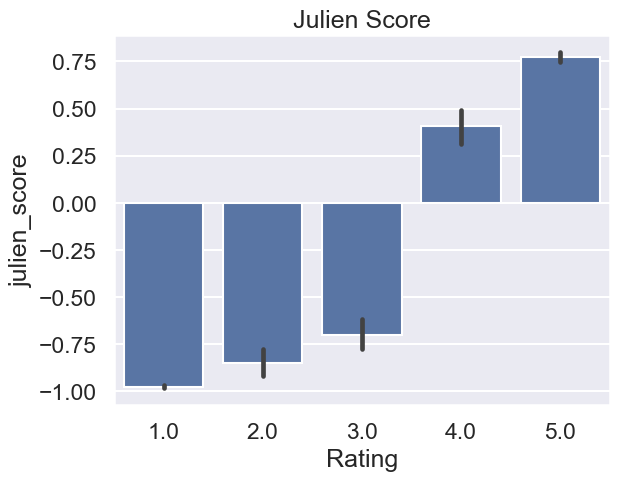

In [4]:
#fig, axs = plt.subplots(1, 3, figsize=(12, 3))
ax=sns.barplot(data=result_final_df, x='Rating', y='julien_score')
ax.set_title('Julien Score')
plt.show()

**Note:** Juliensimon provides the best estimation of the sentiments